In [1]:
import pandas as pd

In [14]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


In [28]:
df = pd.read_excel(r"C:\Users\shiva\Downloads\Trade_Map_-_Bilateral_trade_between_India_and_United_Arab_Emirates (1).xlsx", skiprows=10, header=[0,1])

In [58]:
df.head()

Product code                                      Product label  \
  Unnamed: 0_level_1                                 Unnamed: 1_level_1   
0          '71131911  Articles of jewellery and parts thereof, of pr...   
1          '27101241  Light oils and preparations, of petroleum or b...   
2          '85171300                  Smartphones for wireless networks   
3          '27101939  Medium oils and preparations, of petroleum or ...   
4          '88024000  Aeroplanes and other powered aircraft of an of...   

  India's exports to United Arab Emirates                              \
                            Value in 2022 Value in 2023 Value in 2024   
0                                       0       3270779       3443059   
1                                 3780296       2605151       3274887   
2                                 1846768       2707241       2497824   
3                                  231120       2126308       2197112   
4                                    2320        166625       1615539   

  India's exports to world                                            
        Unnamed: 5_level_1 Value in 2022 Value in 2023 Value in 2024  
0                      NaN             0       4343849       4680167  
1                      NaN      14614035      14523685      11236657  
2                      NaN       7193356      14276348      20441716  
3                      NaN       1027730      16260837      16403587  
4                      NaN         77276        480831       6016953

In [69]:
import re
import numpy as np
import pandas as pd
from typing import List, Optional

YEAR_RE = re.compile(r'\b(19|20)\d{2}\b', re.IGNORECASE)

def _normalize_text(s: Optional[str]) -> Optional[str]:
    if s is None:
        return None
    t = str(s).strip()
    if t.lower() in ("", "nan"):
        return None
    # remove common punctuation, collapse whitespace
    t = re.sub(r"[‘’'\"/\\\-\–\—,:;()]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    return t if t else None

def _slugify(s: str) -> str:
    t = re.sub(r"[^0-9a-zA-Z\s]", "", s)
    t = re.sub(r"\s+", "_", t.strip().lower())
    return t

def clean_multiindex_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flatten and clean multi-index headers from Excel and drop separator columns.
    Produces:
      - product_code
      - product_label
      - <country>_<year>   (for year columns)
    Rules:
      - Drop columns whose header parts are all unnamed/empty.
      - Drop columns that are entirely NA (after normalizing empty strings to NaN).
      - Build names from parent (country/group) + child (year) when possible.
      - Rename first matching code/label columns to product_code/product_label.
      - Strip quotes around product_code/product_label values.
    """
    df_clean = df.copy()

    cols = df_clean.columns
    # treat 1-level as MI of single-tuples for uniform processing
    if not isinstance(cols, pd.MultiIndex):
        cols = pd.MultiIndex.from_tuples([(c,) for c in cols])

    new_col_names: List[Optional[str]] = []
    for tup in cols:
        # collect meaningful parts (skip Unnamed / empty)
        parts = []
        for x in tup:
            nx = _normalize_text(x)
            if nx is not None and "unnamed" not in str(x).lower():
                parts.append(nx)

        # if no meaningful header parts -> mark for drop
        if not parts:
            new_col_names.append(None)
            continue

        # find rightmost year token
        year = None
        for p in reversed(parts):
            m = YEAR_RE.search(p)
            if m:
                year = m.group(0)
                break

        # find country/label piece (first non-year part)
        country = None
        for p in parts:
            if YEAR_RE.search(p):
                continue
            # skip generic "value in" or "value" phrases
            if p.startswith("value in") or p == "value":
                continue
            country = p
            break

        if year and country:
            name = f"{_slugify(country)}_{year}"
        elif year and not country:
            # fallback to year-only name
            name = f"year_{year}"
        else:
            joined = " ".join(parts)
            name = _slugify(joined) if joined else None

        new_col_names.append(name)

    # Apply new column names and drop any falsy names
    df_clean.columns = new_col_names
    df_clean = df_clean.loc[:, [c for c in df_clean.columns if c]]

    # Normalize blank-like strings in data to actual NaN (helps detect all-NA cols)
    df_clean = df_clean.replace(r'^\s*$', np.nan, regex=True)

    # Drop columns that are entirely NA
    all_na_cols = [c for c in df_clean.columns if df_clean[c].isna().all()]
    if all_na_cols:
        df_clean = df_clean.drop(columns=all_na_cols)

    # Heuristic rename for product_code and product_label:
    # Prefer columns that contain 'code' and 'label' respectively; otherwise take first two columns.
    code_col = None
    label_col = None
    for c in df_clean.columns:
        if code_col is None and "code" in c:
            code_col = c
        if label_col is None and ("label" in c or "description" in c):
            label_col = c
        if code_col and label_col:
            break

    cols_remaining = list(df_clean.columns)
    if code_col is None and len(cols_remaining) >= 1:
        code_col = cols_remaining[0]
    # prefer second column for label if not detected
    if label_col is None and len(cols_remaining) >= 2:
        label_col = cols_remaining[1]

    if code_col:
        df_clean = df_clean.rename(columns={code_col: "product_code"})
    if label_col:
        df_clean = df_clean.rename(columns={label_col: "product_label"})

    # Final sanitation: strip surrounding quotes/whitespace from product_code and product_label
    if "product_code" in df_clean.columns:
        df_clean["product_code"] = (
            df_clean["product_code"]
            .astype(str)
            .str.strip()
            .str.strip("'\"")
            .replace({'nan': None})
        )

    if "product_label" in df_clean.columns:
        df_clean["product_label"] = (
            df_clean["product_label"]
            .astype(str)
            .str.strip()
            .str.strip("'\"")
            .replace({'nan': None})
        )

    # reset index and return
    df_clean = df_clean.reset_index(drop=True)
    return df_clean


In [70]:
# ===== usage =====
# If you read from Excel ensure header=[0,1] (or match number of header rows):
df_clean = clean_multiindex_columns(df)
# print(df_clean.columns.tolist())

In [71]:
df_clean.head()

,product_code,product_label,india_s_exports_to_united_arab_emirates_2022,india_s_exports_to_united_arab_emirates_2023,india_s_exports_to_united_arab_emirates_2024,india_s_exports_to_world_2022,india_s_exports_to_world_2023,india_s_exports_to_world_2024
0,71131911,"Articles of jewellery and parts thereof, of pr...",0,3270779,3443059,0,4343849,4680167
1,27101241,"Light oils and preparations, of petroleum or b...",3780296,2605151,3274887,14614035,14523685,11236657
2,85171300,Smartphones for wireless networks,1846768,2707241,2497824,7193356,14276348,20441716
3,27101939,"Medium oils and preparations, of petroleum or ...",231120,2126308,2197112,1027730,16260837,16403587
4,88024000,Aeroplanes and other powered aircraft of an of...,2320,166625,1615539,77276,480831,6016953


In [72]:
seven_o_six_data = pd.read_csv(r"C:\Users\shiva\Downloads\70somthing.csv")

In [84]:
# Drop useless columns
df_706 = seven_o_six_data.drop(columns=[c for c in df.columns if "Unnamed" in c])

# # Clean the remaining column
df_706["8 Digit"] = df_706["8 Digit"].astype(str).str.strip().str.replace(r"\D", "", regex=True)

df_706["8 Digit"] = df_706["8 Digit"].astype(np.int64)
# # Drop empty rows
df_706 = df_706[df_706["8 Digit"] != ""].reset_index(drop=True)

In [86]:


unnamed_cols = df_706.filter(regex='(?i)Unnamed').columns

# Drop those columns from the DataFrame
df_706 = df_706.drop(columns=unnamed_cols, axis=1)


In [87]:
df_706

,8 Digit
0,84021200
1,84021910
2,84021920
3,84021990
4,84029020
...,...
432,85371000
433,85372000
434,87041010
435,87054000


In [92]:
count = df_clean['product_code'].nunique()

In [93]:
count

11834

In [94]:
df_filtered = df_clean[df_clean['product_code'].astype(str)
                                       .isin(df_706['8 Digit'].astype(str))]


In [95]:
count_filtered = df_filtered['product_code'].nunique()

In [96]:
count_filtered

431

In [102]:
df_filtered

,product_code,product_label,india_s_exports_to_united_arab_emirates_2022,india_s_exports_to_united_arab_emirates_2023,india_s_exports_to_united_arab_emirates_2024,india_s_exports_to_world_2022,india_s_exports_to_world_2023,india_s_exports_to_world_2024
61,84295200,"Self-propelled mechanical shovels, excavators ...",32594,58207,59651,363837,425112,536384
82,87041010,Dumpers for off-highway use: Dumpers designed ...,21097,29676,42818,639402,741571,584144
83,84295900,"Self-propelled mechanical shovels, excavators ...",14271,19131,42168,395608,410011,432873
95,84314390,Parts for boring or sinking machinery of subhe...,17613,28211,37918,139878,150745,195071
160,84798999,"Machines and mechanical appliances, n.e.s.: Other",6280,15641,24471,422354,386512,438044
...,...,...,...,...,...,...,...,...
11545,84589943,"Lathes, incl. turning centres, for removing me...",0,0,0,15,1490,1137
11546,84593100,"Boring-milling machines for metals, numericall...",0,0,0,111,844,433
11547,84592940,"Drilling machines for working metal, not numer...",2,0,0,3733,1685,1370
11548,84639020,"Machine tools for working metal, sintered meta...",0,0,0,260,417,108


In [110]:
country_slug = df_filtered.columns[2].rsplit("_", 1)[0]

In [111]:
country_slug

'india_s_exports_to_united_arab_emirates'

In [112]:
year_cols = [c for c in df_filtered.columns if c.startswith(country_slug) and c[-4:].isdigit()]


In [113]:
year_cols

['india_s_exports_to_united_arab_emirates_2022',
 'india_s_exports_to_united_arab_emirates_2023',
 'india_s_exports_to_united_arab_emirates_2024']

In [114]:
latest_col = sorted(year_cols)[-1]

In [115]:
df_sorted = df_filtered.sort_values(latest_col, ascending=False)

In [117]:
df_sorted.head().to_clipboard()

In [118]:
year = latest_col[-4:]   

In [119]:
year

'2024'

In [120]:
# 3) build output DataFrame
df_out = df_filtered.copy()

# ensure numeric (coerce errors to NaN)
df_out[latest_col] = pd.to_numeric(df_out[latest_col], errors='coerce')

# convert to millions by dividing by 1000 (as you requested)
df_out['value_millions'] = df_out[latest_col] / 1000.0

# format as $X.XXM (two decimals). replace NaN with empty string if you want.
export_col_name = f'EXPORT VALUE ({year} USD Million)'
df_out[export_col_name] = df_out['value_millions'].map(lambda x: f"${x:.2f}M" if pd.notnull(x) else "")

# final column names you asked for
df_final = df_out.rename(columns={
    'product_code': 'HSCODE',
    'product_label': 'DESCRIPTION'
})[['HSCODE', 'DESCRIPTION', export_col_name]]

# sort by numeric millions value descending
df_final = df_final.assign(_sort_val=df_out['value_millions']).sort_values('_sort_val', ascending=False).drop(columns=['_sort_val'])

# reset index and show top results
df_final = df_final.reset_index(drop=True)

In [125]:
df_final.head().to_clipboard()

In [124]:
df_final

,HSCODE,DESCRIPTION,EXPORT VALUE (2024 USD Million)
0,84295200,"Self-propelled mechanical shovels, excavators ...",$59.65M
1,87041010,Dumpers for off-highway use: Dumpers designed ...,$42.82M
2,84295900,"Self-propelled mechanical shovels, excavators ...",$42.17M
3,84314390,Parts for boring or sinking machinery of subhe...,$37.92M
4,84798999,"Machines and mechanical appliances, n.e.s.: Other",$24.47M
...,...,...,...
426,84454020,"Textile winding, incl. weft-winding, or reelin...",$0.00M
427,84454010,"Textile winding, incl. weft-winding, or reelin...",$0.00M
428,84453050,Textile doubling or twisting machines: Wool do...,$0.00M
429,84461012,Weaving machines for weaving fabrics of a widt...,$0.00M


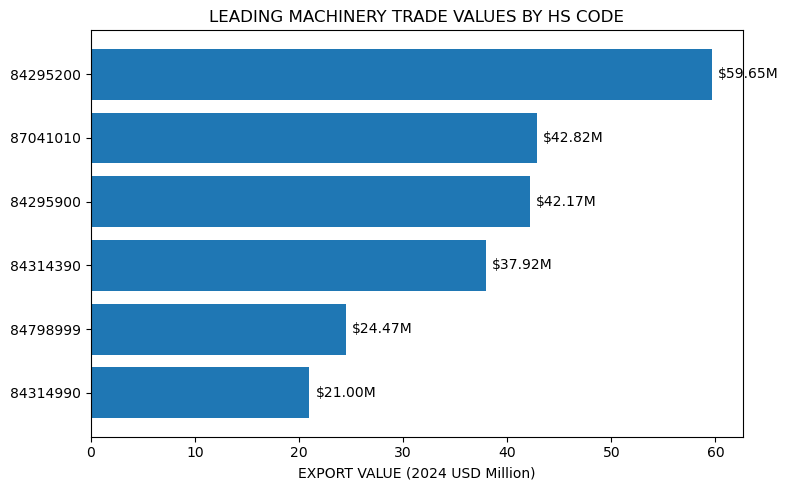

In [126]:
import matplotlib.pyplot as plt

# df_final already exists
year = latest_col[-4:]   # same variable you already have

# take top N
top_n = 6
df_plot = df_final.head(top_n).copy()

# extract numeric again (because df_final only has the formatted "$XXM")
df_plot['val'] = df_out['value_millions'].head(top_n).values

fig, ax = plt.subplots(figsize=(8,5))
y = range(len(df_plot))

bars = ax.barh(y, df_plot['val'])

ax.invert_yaxis()

ax.set_yticks(y)
ax.set_yticklabels(df_plot['HSCODE'].astype(str).values)

# add formatted labels already existing in df_final
for i, lbl in enumerate(df_plot[f'EXPORT VALUE ({year} USD Million)']):
    ax.text(df_plot['val'][i] + 0.01 * df_plot['val'].max(), i, lbl, va='center')

ax.set_title('LEADING MACHINERY TRADE VALUES BY HS CODE')
ax.set_xlabel(f'EXPORT VALUE ({year} USD Million)')

plt.tight_layout()
plt.show()


In [127]:
df_sorted.head().to_clipboard()

In [128]:
df_sorted

,product_code,product_label,india_s_exports_to_united_arab_emirates_2022,india_s_exports_to_united_arab_emirates_2023,india_s_exports_to_united_arab_emirates_2024,india_s_exports_to_world_2022,india_s_exports_to_world_2023,india_s_exports_to_world_2024
61,84295200,"Self-propelled mechanical shovels, excavators ...",32594,58207,59651,363837,425112,536384
82,87041010,Dumpers for off-highway use: Dumpers designed ...,21097,29676,42818,639402,741571,584144
83,84295900,"Self-propelled mechanical shovels, excavators ...",14271,19131,42168,395608,410011,432873
95,84314390,Parts for boring or sinking machinery of subhe...,17613,28211,37918,139878,150745,195071
160,84798999,"Machines and mechanical appliances, n.e.s.: Other",6280,15641,24471,422354,386512,438044
...,...,...,...,...,...,...,...,...
11027,84454020,"Textile winding, incl. weft-winding, or reelin...",0,0,0,19,13,15
11026,84454010,"Textile winding, incl. weft-winding, or reelin...",17,121,0,623,984,315
11025,84453050,Textile doubling or twisting machines: Wool do...,0,2,0,0,14,0
11024,84461012,Weaving machines for weaving fabrics of a widt...,0,0,0,0,1,18


In [134]:
df_clean.head().to_clipboard()

In [135]:
# 1) get country slug from df_clean
country_slug = df_clean.columns[2].rsplit("_", 1)[0]

# 2) pick only the relevant columns for that country (all years)
year_cols = [c for c in df_clean.columns if c.startswith(country_slug) and c[-4:].isdigit()]

# 3) latest year column
latest_col = sorted(year_cols)[-1]

# 4) sum the latest year's export values
total_export_value = df_clean[latest_col].sum()

# 5) convert to billions  (values → million → billion)
total_export_value_billion = total_export_value / 1000 / 1000

total_export_value_billion


37.766939

In [138]:
# 1) get country slug from df_filtered
country_slug = df_filtered.columns[2].rsplit("_", 1)[0]

# 2) select all year columns for that country
year_cols_filtered = [c for c in df_filtered.columns if c.startswith(country_slug) and c[-4:].isdigit()]

# 3) pick the latest year column
latest_col_filtered = sorted(year_cols_filtered)[-1]

# 4) sum exports for that latest year (HEMT only)
hemt_export_value = df_filtered[latest_col_filtered].sum()

# 5) convert to billions
hemt_export_value_billion = hemt_export_value / 1000 / 1000

hemt_export_value_billion


0.49010899999999996

In [139]:
country_slug

'india_s_exports_to_united_arab_emirates'

AttributeError: module 'matplotlib.pyplot' has no attribute 'cos'

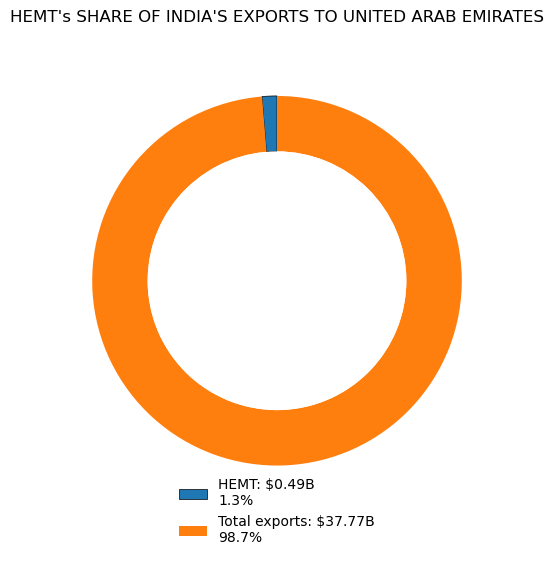

In [140]:
import matplotlib.pyplot as plt

# ---------- get country slug and latest year column (dynamic) ----------
country_slug = df_clean.columns[2].rsplit("_", 1)[0]
year_cols = [c for c in df_clean.columns if c.startswith(country_slug) and c[-4:].isdigit()]
latest_col = sorted(year_cols)[-1]

# ---------- totals (convert to billions: value -> million -> billion i.e. /1_000_000) ----------
total_value = df_clean[latest_col].sum()
total_value_b = total_value / 1_000_000  # in billions

# ---------- HEMT (filtered df) using same country slug and latest year ----------
year_cols_f = [c for c in df_filtered.columns if c.startswith(country_slug) and c[-4:].isdigit()]
latest_col_f = sorted(year_cols_f)[-1]
hemt_value = df_filtered[latest_col_f].sum()
hemt_value_b = hemt_value / 1_000_000  # in billions

# ---------- prepare pie/donut data ----------
other_value_b = max(total_value_b - hemt_value_b, 0)  # avoid negative due to rounding
sizes = [hemt_value_b, other_value_b]
labels = [
    f"HEMT: ${hemt_value_b:,.2f}B\n{(hemt_value_b/total_value_b*100 if total_value_b else 0):.1f}%",
    f"Total exports: ${total_value_b:,.2f}B\n{(other_value_b/total_value_b*100 if total_value_b else 0):.1f}%"
]

# ---------- pretty country display name ----------
display_country = country_slug.replace("india_s_exports_to_", "").replace("_", " ").title()

# ---------- plot donut chart ----------
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts = ax.pie(sizes, startangle=90, wedgeprops=dict(width=0.30))

# emphasize the HEMT slice with a slight explode effect (if it's the first slice)
wedges[0].set_edgecolor("k")
wedges[0].set_linewidth(0.5)

# central circle to make it a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax.add_artist(centre_circle)

# title
ax.set_title(f"HEMT's SHARE OF INDIA'S EXPORTS TO {display_country.upper()}", fontsize=12, pad=20)

# legend (use the formatted labels)
ax.legend(wedges, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), frameon=False)

# annotation for the small slice (HEMT) - place above the slice
pct = (hemt_value_b / total_value_b * 100) if total_value_b else 0
annot_text = f"${hemt_value_b:,.2f}B, {pct:.1f}%"
# find angle to place annotation near the HEMT wedge
ang = (wedges[0].theta2 + wedges[0].theta1) / 2.
x = 1.1 * plt.cos(ang * plt.pi / 180.)
y = 1.1 * plt.sin(ang * plt.pi / 180.)
ax.annotate(annot_text, xy=(x, y), xytext=(1.4 * (1 if x>=0 else -1), 1.4 * (1 if y>=0 else -1)),
            arrowprops=dict(arrowstyle='->', linewidth=0.8), bbox=dict(boxstyle="round,pad=0.3"))

# equal aspect ratio ensures pie is drawn as a circle
ax.axis('equal')
plt.tight_layout()
plt.show()
